In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
# Function to get stock tickers from user input
def get_string_array():
    while True:
        user_input = input("Enter stock tickers, separated by commas: ")
        tickers = [s.strip() for s in user_input.split(',')]
        if all(tickers):  # Check if all tickers are non-empty
            return tickers
        print("Please enter valid tickers.")

# Function to fetch stock data from Yahoo Finance
def fetch_stock_data(tickers, start_date, end_date):
    closing_prices = {}
    for ticker in tickers:
        stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d')
        if stock_data.empty:
            print(f"Stock with ticker symbol: {ticker} does not exist.")
            continue
        closing_prices[ticker] = stock_data['Close']
    return pd.DataFrame(closing_prices)

# Function to calculate mean, standard deviation, and variance
def calculate_statistics(returns):
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()
    mean_returns = returns.mean().values
    std_devs = returns.std().values
    variances = returns.var().values
    stats_df = pd.DataFrame({
        'Mean Return': mean_returns,
        'Std Dev': std_devs,
        'Variance': variances
    }, index=returns.columns)
    return stats_df

# Function to calculate returns and statistics
def calculate_returns_and_stats(df):
    daily_returns = df.pct_change().dropna()
    return calculate_statistics(daily_returns)

# Function to calculate the efficient frontier
def calculate_efficient_frontier(returns, risk_free_rate=0.0, num_portfolios=10000):
    num_assets = returns.shape[1]
    results = np.zeros((3, num_portfolios))  # Portfolio returns, risks, and Sharpe ratios
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)  # Normalize weights to sum to 1
        weights_record.append(weights)

        portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized returns
        results[0, i] = portfolio_return

        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized risk
        results[1, i] = portfolio_std_dev

        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Sharpe ratio

    return results, weights_record

# Function to optimize portfolio for maximum return given a target risk
def optimize_portfolio_max_return(returns, target_std_dev):
    num_assets = returns.shape[1]

    def portfolio_performance(weights):
        portfolio_return = np.sum(returns.mean() * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        return portfolio_std_dev, portfolio_return

    def objective_function(weights):
        return -portfolio_performance(weights)[1]  # Maximize return

    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'ineq', 'fun': lambda weights: target_std_dev - portfolio_performance(weights)[0]}
    ]

    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets,]

    result = minimize(objective_function, initial_weights, bounds=bounds, constraints=constraints)
    return result.x if result.success else None

# Function to optimize portfolio for minimum risk given a target return
def optimize_portfolio_min_risk(returns, target_return):
    num_assets = returns.shape[1]

    def portfolio_performance(weights):
        portfolio_return = np.sum(returns.mean() * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        return portfolio_std_dev, portfolio_return

    def objective_function(weights):
        return portfolio_performance(weights)[0]  # Minimize risk

    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: portfolio_performance(weights)[1] - target_return}
    ]

    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets,]

    result = minimize(objective_function, initial_weights, bounds=bounds, constraints=constraints)
    return result.x if result.success else None

# Function to plot the efficient frontier
def plot_efficient_frontier(results, risk_free_rate=0.0):
    plt.figure(figsize=(10, 7))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier')
    plt.grid()

    if risk_free_rate > 0:
        plt.axvline(x=0, color='r', linestyle='--')
        plt.text(0, risk_free_rate, 'Risk-Free Rate', color='red', verticalalignment='bottom')

    plt.show()

# Function to calculate portfolio performance
def calculate_portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std_dev

# Fetch the current risk-free rate (T-Bill rate)
def fetch_tbill_rate(start_date, end_date, ticker='^IRX'):
    tbill_data = yf.Ticker(ticker)
    tbill_history = tbill_data.history(start=start_date, end=end_date)
    tbill_rate = tbill_history['Close'].mean()
    return tbill_rate / 100



In [ ]:
# Define date range
date1 = '2021-01-06'
date2 = '2022-01-09'

# Fetch the average risk-free rate (T-Bill rate) over the specified date range
risk_free_rate = fetch_tbill_rate(date1, date2)
print("Average Risk-Free Rate (from T-Bill) over the period:", risk_free_rate)

Average Risk-Free Rate (from T-Bill) over the period: 0.00035188235452069956


aapl, msft, nvda, jnj, pfe, amzn, tsla, jpm, bac, nee, duk, xom, cvx, pg, ko, baba, spy, vti, eem

a variations of stocks

duk, xom, cvx, pg, ko, baba, spy, vti

try this combination to get a nice efficient frontier


Enter stock tickers, separated by commas: duk, xom, cvx, pg, ko, baba, spy, vti
You entered: ['duk', 'xom', 'cvx', 'pg', 'ko', 'baba', 'spy', 'vti']
                                 duk        xom         cvx          pg  \
Date                                                                      
2021-01-06 00:00:00-05:00  77.433968  37.798340   75.974113  126.945953   
2021-01-07 00:00:00-05:00  76.565155  38.094902   76.329453  125.759422   
2021-01-08 00:00:00-05:00  76.701454  38.518551   77.057045  125.705124   
2021-01-11 00:00:00-05:00  76.054115  39.687836   77.496979  124.853722   
2021-01-12 00:00:00-05:00  75.747482  40.569038   78.969086  124.129143   
...                              ...        ...         ...         ...   
2022-01-03 00:00:00-05:00  91.643501  57.148403  106.186836  151.253052   
2022-01-04 00:00:00-05:00  91.572662  59.297997  108.118965  151.782272   
2022-01-05 00:00:00-05:00  91.776321  60.035500  108.822372  152.469376   
2022-01-06 00:00:00-05:00 

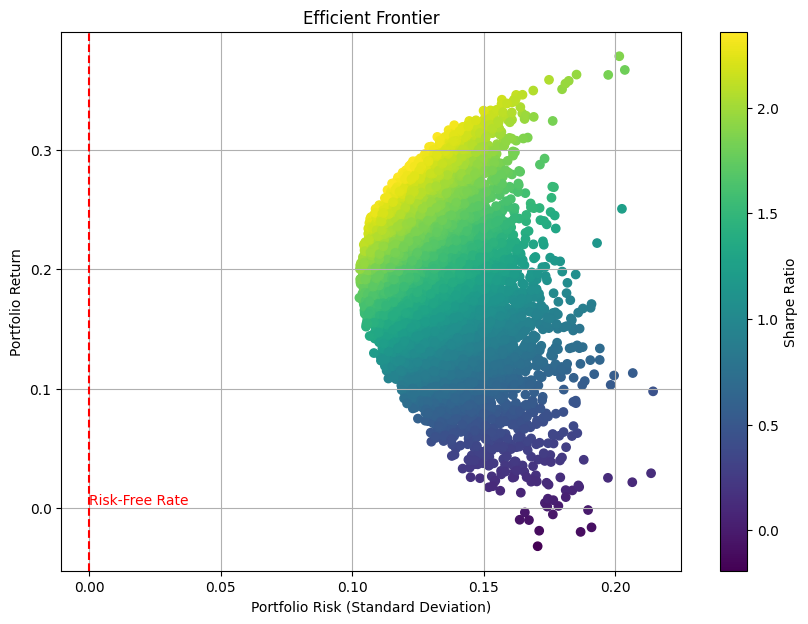

In [ ]:
# User input for stock tickers
tickers = get_string_array()
print("You entered:", tickers)

# Fetch stock data
stock_df = fetch_stock_data(tickers, date1, date2)
print(stock_df)

# Calculate statistics for stocks
daily_stats_df = calculate_returns_and_stats(stock_df)
print("Daily Statistics:\n", daily_stats_df)

# Calculate daily returns for the stock DataFrame
daily_returns_combined = stock_df.pct_change().dropna()

# Calculate efficient frontier
results, weights_record = calculate_efficient_frontier(daily_returns_combined, risk_free_rate, num_portfolios=10000)

# Plot the efficient frontier
plot_efficient_frontier(results, risk_free_rate)

In [ ]:
# User input for risk tolerance with error handling
while True:
    try:
        target_risk = float(input("Enter your desired portfolio risk (standard deviation): "))
        break
    except ValueError:
        print("Please enter a valid number.")

# Optimize portfolio weights based on user-defined risk
optimal_weights = optimize_portfolio_max_return(daily_returns_combined, target_risk)

# Display the optimal weights and calculate risk and return
if optimal_weights is not None:
    optimal_weights_df = pd.DataFrame(optimal_weights, index=daily_returns_combined.columns, columns=['Optimal Weight'])
    print("\nOptimal Weights for Your Portfolio:\n", optimal_weights_df)

    # Validate weights
    total_weight = optimal_weights_df['Optimal Weight'].sum()
    print("\nSum of Optimal Weights:", total_weight)
    print("The sum of the optimal weights equals 1." if np.isclose(total_weight, 1.0, atol=1e-6) else "The sum of the optimal weights does not equal 1.")

    # Calculate portfolio return and risk
    portfolio_return, portfolio_std_dev = calculate_portfolio_performance(optimal_weights, daily_returns_combined)
    print("\nExpected Portfolio Return:", portfolio_return)
    print("Portfolio Risk (Standard Deviation):", portfolio_std_dev)
else:
    print("Could not find optimal weights for the specified risk tolerance.")

# User input for desired return with error handling
while True:
    try:
        desired_return = float(input("Enter your desired portfolio return: "))
        break
    except ValueError:
        print("Please enter a valid number.")

# Optimize portfolio weights for minimum risk given the desired return
optimal_weights_min_risk = optimize_portfolio_min_risk(daily_returns_combined, desired_return)

# Display the optimal weights for minimum risk
if optimal_weights_min_risk is not None:
    optimal_weights_df_min_risk = pd.DataFrame(optimal_weights_min_risk, index=daily_returns_combined.columns, columns=['Optimal Weight'])
    print("\nOptimal Weights for Minimum Risk at Desired Return:\n", optimal_weights_df_min_risk)

    # Validate weights
    total_weight_min_risk = optimal_weights_df_min_risk['Optimal Weight'].sum()
    print("\nSum of Optimal Weights:", total_weight_min_risk)

    # Portfolio performance calculations
    portfolio_return, portfolio_std_dev = calculate_portfolio_performance(optimal_weights_min_risk, daily_returns_combined)
    print("\nExpected Portfolio Return:", portfolio_return)
    print("Portfolio Risk (Standard Deviation):", portfolio_std_dev)
else:
    print("Could not find optimal weights for the specified return.")

Enter your desired portfolio risk (standard deviation): 0.15

Optimal Weights for Your Portfolio:
       Optimal Weight
duk     2.331265e-01
xom     4.158198e-01
cvx     0.000000e+00
pg      7.514356e-02
ko      1.683989e-03
baba    5.529702e-16
spy     2.742261e-01
vti     0.000000e+00

Sum of Optimal Weights: 1.0000000000000007
The sum of the optimal weights equals 1.

Expected Portfolio Return: 0.34642871729964525
Portfolio Risk (Standard Deviation): 0.1500009443982721
Enter your desired portfolio return: 0.25

Optimal Weights for Minimum Risk at Desired Return:
       Optimal Weight
duk     2.325312e-01
xom     1.123774e-01
cvx     0.000000e+00
pg      1.882700e-01
ko      4.927237e-02
baba    0.000000e+00
spy     4.175490e-01
vti     1.019150e-17

Sum of Optimal Weights: 0.9999999999999999

Expected Portfolio Return: 0.24999999999961628
Portfolio Risk (Standard Deviation): 0.10692031408704979
